In [1]:
import os
import cv2
import numpy as np

def is_image_file(filename):
    """Check if a file is an image based on its extension."""
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    return filename.lower().endswith(valid_extensions)

def load_images(folder, target_size=(128, 128)):
    images, labels = [], []
    
    if not os.path.exists(folder):
        print(f"Error: Path '{folder}' does not exist!")
        return images, labels, {}

    train_path = os.path.join(folder, "Train")
    test_path = os.path.join(folder, "Test")

    all_folders = []
    if os.path.exists(train_path):
        all_folders.append(train_path)
    if os.path.exists(test_path):
        all_folders.append(test_path)

    class_dict = {}
    class_index = 0

    for main_folder in all_folders:
        class_names = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
        
        for class_name in class_names:
            if class_name not in class_dict:
                class_dict[class_name] = class_index
                class_index += 1

            class_folder = os.path.join(main_folder, class_name)
            for filename in os.listdir(class_folder):
                if is_image_file(filename):
                    img_path = os.path.join(class_folder, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, target_size)
                        images.append(img)
                        labels.append(class_dict[class_name])
                    else:
                        print(f"Warning: Could not read {img_path}")

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images, labels, class_dict

X, y, class_map = load_images("/kaggle/input/fingernails-data-2balance/Fingernails data 2(balance)")
print(f"Loaded {len(X)} images with {len(class_map)} classes.")

Loaded 6430 images with 2 classes.


In [2]:
import cv2
import numpy as np

def extract_color_histogram(images, bins=(8, 8, 8)):
    features = []
    for img in images:
        img = (img * 255).astype(np.uint8)  
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  
        hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()  
        features.append(hist)
    return np.array(features)
X_features = extract_color_histogram(X)

In [3]:
print(f"Feature array shape: {X_features.shape}")  # Should not be (0,)


Feature array shape: (6430, 512)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 5144, Testing samples: 1286


In [5]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Accuracy
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print(f"Random Forest Train Accuracy: {accuracy_rf_train:.4f}")  
print(f"Random Forest Test Accuracy: {accuracy_rf_test:.4f}")  

# Print Classification Reports
print("\nRandom Forest Train Classification Report:\n")
print(classification_report(y_train, y_pred_rf_train))

print("\nRandom Forest Test Classification Report:\n")
print(classification_report(y_test, y_pred_rf_test))

Random Forest Train Accuracy: 1.0000
Random Forest Test Accuracy: 1.0000

Random Forest Train Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2552
           1       1.00      1.00      1.00      2592

    accuracy                           1.00      5144
   macro avg       1.00      1.00      1.00      5144
weighted avg       1.00      1.00      1.00      5144


Random Forest Test Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00       623

    accuracy                           1.00      1286
   macro avg       1.00      1.00      1.00      1286
weighted avg       1.00      1.00      1.00      1286



In [6]:
import joblib
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved as random_forest_model.pkl")

Model saved as random_forest_model.pkl


In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=200,        
    max_depth=10,            
    learning_rate=0.1,       
    subsample=0.8,            
    colsample_bytree=0.8,     
    gamma=0.1,                
    reg_lambda=1.0,          
    reg_alpha=0.5,            
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Accuracy
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print(f"XGBoost Train Accuracy: {accuracy_xgb_train:.4f}")
print(f"XGBoost Test Accuracy: {accuracy_xgb_test:.4f}")

# Print Classification Report
print("\nXGBoost Train Classification Report:\n", classification_report(y_train, y_pred_xgb_train))
print("\nXGBoost Test Classification Report:\n", classification_report(y_test, y_pred_xgb_test))

# Print Confusion Matrix
print("\nXGBoost Train Confusion Matrix:\n", confusion_matrix(y_train, y_pred_xgb_train))
print("\nXGBoost Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_test))

XGBoost Train Accuracy: 1.0000
XGBoost Test Accuracy: 1.0000

XGBoost Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2552
           1       1.00      1.00      1.00      2592

    accuracy                           1.00      5144
   macro avg       1.00      1.00      1.00      5144
weighted avg       1.00      1.00      1.00      5144


XGBoost Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00       623

    accuracy                           1.00      1286
   macro avg       1.00      1.00      1.00      1286
weighted avg       1.00      1.00      1.00      1286


XGBoost Train Confusion Matrix:
 [[2552    0]
 [   0 2592]]

XGBoost Test Confusion Matrix:
 [[663   0]
 [  0 623]]


In [8]:
joblib.dump(xgb_model, "xgboost_model.pkl")
print("\nModel saved as xgboost_model.pkl")


Model saved as xgboost_model.pkl


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Print best parameters
print("Best XGBoost Parameters:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

# Evaluate best model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Tuned XGBoost Train Accuracy: {accuracy_train:.4f}")
print(f"Tuned XGBoost Test Accuracy: {accuracy_test:.4f}")

# Print classification reports
print("\nXGBoost Classification Report (Train):\n", classification_report(y_train, y_pred_train))
print("\nXGBoost Classification Report (Test):\n", classification_report(y_test, y_pred_test))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 200, 'subsample': 1.0}
Tuned XGBoost Train Accuracy: 1.0000
Tuned XGBoost Test Accuracy: 1.0000

XGBoost Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2552
           1       1.00      1.00      1.00      2592

    accuracy                           1.00      5144
   macro avg       1.00      1.00      1.00      5144
weighted avg       1.00      1.00      1.00      5144


XGBoost Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00       623

    accuracy                           1.00      1286
   macro avg       1.00      1.00      1.00      1286
weighted avg       1.00      1.00      1.00      1286



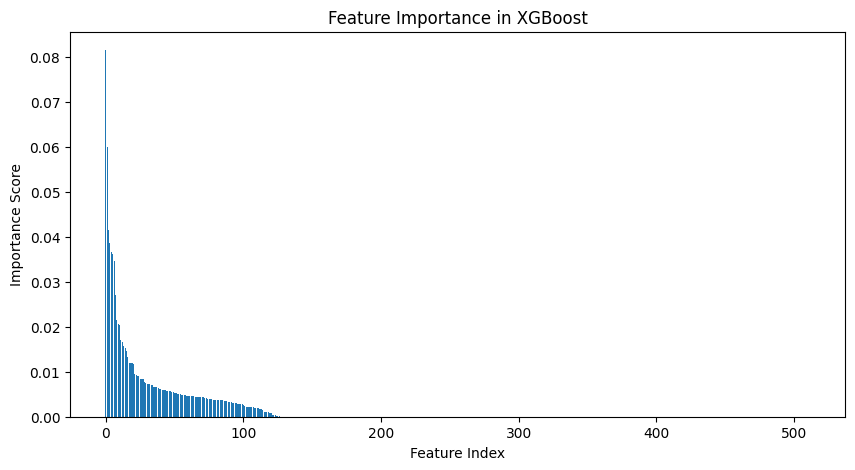

In [10]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in XGBoost")
plt.show()

In [11]:
joblib.dump(xgb_model, "xgboost_tunnig_model.pkl")
print("\nModel saved as xgboost_tunnig_model.pkl")


Model saved as xgboost_tunnig_model.pkl


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions for Decision Tree
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)

# Accuracy for Decision Tree
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt_test)

print(f"Decision Tree Train Accuracy: {accuracy_dt_train:.4f}")
print(f"Decision Tree Test Accuracy: {accuracy_dt_test:.4f}")

# Print classification reports for Decision Tree
print("\nDecision Tree Classification Report (Train):\n", classification_report(y_train, y_pred_dt_train))
print("\nDecision Tree Classification Report (Test):\n", classification_report(y_test, y_pred_dt_test))

Decision Tree Train Accuracy: 1.0000
Decision Tree Test Accuracy: 1.0000

Decision Tree Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2552
           1       1.00      1.00      1.00      2592

    accuracy                           1.00      5144
   macro avg       1.00      1.00      1.00      5144
weighted avg       1.00      1.00      1.00      5144


Decision Tree Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00       623

    accuracy                           1.00      1286
   macro avg       1.00      1.00      1.00      1286
weighted avg       1.00      1.00      1.00      1286



In [13]:
joblib.dump(xgb_model, "DecisionTree_model.pkl")
print("\nModel saved as DecisionTree_model.pkl")


Model saved as DecisionTree_model.pkl
